# Food Vision - Milestone

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Getting helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Using TensorFlow Datasets (TFDS)

In [3]:
# Getting TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# Listing all available datasets
datasets_list = tfds.list_builders()
#datasets_list

In [5]:
# Loading in the data
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

### Exploring TFDS Food101 dataset

In [6]:
# Features of Food101 dataset from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Taking one sample of train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class: {label}
    Class name(str form): {class_names[label.numpy()]}
    """)


    Image shape: (306, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class: 29
    Class name(str form): cup_cakes
    


In [10]:
# Sample image structure
image

<tf.Tensor: shape=(306, 512, 3), dtype=uint8, numpy=
array([[[199, 100,  15],
        [192,  91,   9],
        [202,  95,  23],
        ...,
        [238, 196, 124],
        [237, 195, 123],
        [236, 194, 122]],

       [[210, 110,  25],
        [207, 105,  23],
        [194,  86,  13],
        ...,
        [238, 196, 124],
        [236, 194, 122],
        [235, 193, 121]],

       [[205, 103,  18],
        [213, 108,  25],
        [196,  86,  11],
        ...,
        [238, 195, 126],
        [237, 194, 125],
        [235, 192, 123]],

       ...,

       [[ 95,  28,  11],
        [ 94,  27,  10],
        [ 84,  17,   0],
        ...,
        [166,  32,   5],
        [166,  32,   3],
        [167,  34,   1]],

       [[ 87,  24,   7],
        [ 83,  18,   0],
        [ 87,  20,   1],
        ...,
        [155,  27,   0],
        [164,  39,   9],
        [156,  33,   0]],

       [[ 83,  21,   6],
        [ 79,  16,   0],
        [ 85,  19,   0],
        ...,
        [149,  25,   

In [11]:
# Checking image's min/max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plotting TFDS sample image

(-0.5, 511.5, 305.5, -0.5)

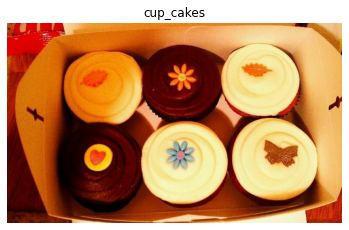

In [15]:
# Plotting an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Building a preprocessing function

In [16]:
# Making a function
def preprocess_img(image, label, img_shape=224):
    # Resize the image
    image = tf.image.resize(image, [img_shape, img_shape])
    # image = image / 255. # Optional rescaling
    # Convert image from uint8 to float32
    return tf.cast(image, tf.float32), label

In [17]:
# Preporcessing sample tensor
preprocessed_img = preprocess_img(image, label)[0]
print(f"""
Image before preprocessing: {image[:2]}
Image shape: {image.shape}
Image data type: {image.dtype}
Image after preprocessing: {preprocessed_img[:2]}
Image shape: {preprocessed_img.shape}
Image data type: {preprocessed_img.dtype}
""")


Image before preprocessing: [[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]]
Image shape: (306, 512, 3)
Image data type: <dtype: 'uint8'>
Image after preprocessing: [[[196.98405    96.515305   13.443877 ]
  [185.15625    75.776146   10.615431 ]
  [176.09981    62.711414    9.320153 ]
  ...
  [237.2455    192.6027    122.24549  ]
  [238.        196.        124.       ]
  [236.4598    194.4598    122.459785 ]]

 [[209.20886   106.47194    23.047512 ]
  [168.58833    56.285706    0.8501243]
  [166.6894     53.45121     2.8341837]
  ...
  [236.62468   192.2172    121.85998  ]
  [238.50987   195.96077   125.60809  ]
  [235.9958    193.4467    123.09402  ]]]
Image shape: (224, 224, 3)
Image data type: <dtype: 'float32'>



### Batch and prepare datasets

In [18]:
# Map preprocessing function to training (and parallelise it)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle training data and turn into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)